In [389]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import copy
import warnings
from sklearn.manifold import TSNE

from torchsummary import summary
from pthflops import count_ops
warnings.filterwarnings('ignore')
torch.cuda.empty_cache()

In [390]:
#!unzip /content/Natural-Faces.zip                                         # CODE TO MOVE IMAGES FROM ONE FOLDER TO ANOTHER
# import os, random
# import shutil

# m=10

# src_dir = "C:/Users/occul/Desktop/Datasets/Natural-Faces/train/contempt/"
# dst_dir = "C:/Users/occul/Desktop/Datasets/Natural-Faces/test/contempt/"

# file_list = os.listdir(src_dir)

# for i in range(m):
    
#     a = random.choice(file_list)
#         #file_list.remove(a)
#     shutil.move(src_dir + a, dst_dir+ a)

In [391]:
def load_data(train_path, batch_size,input_size,mn,sd,shuffle_test=False):
    
    
    transform_dict={"src":transforms.Compose([transforms.ToTensor(),transforms.Resize(size=input_size),transforms.Normalize(mean=mn,std=sd),
            transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip(),
            transforms.RandomRotation(degrees=180),transforms.RandomAdjustSharpness(sharpness_factor=1.4)])}

    train=datasets.ImageFolder(root=train_path,transform=transform_dict["src"])
    
    
    labelslist=train.class_to_idx
    dataset_size = len(train)
    
    train_size = int(round(0.80 * dataset_size))
    test_size = int(round(0.10 * dataset_size))
    val_size = int(round(0.10 * dataset_size))
    if(dataset_size-(train_size+test_size+val_size)>0):
      val_size=val_size+1
    elif(dataset_size-(train_size+test_size+val_size)<0):
      val_size=val_size-1
    

    train_dataset,test_dataset,val_dataset = torch.utils.data.random_split(train,[train_size,test_size,val_size])
    

    

    print('Size Of Train Dataset',len(train_dataset))
    print('Size Of Test Dataset',len(test_dataset))
    print('Size Of Validation Dataset',len(val_dataset))
   

    data_loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
    shuffle=True, drop_last=False,num_workers=0)
    data_loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
    shuffle=False, drop_last=False,num_workers=0)
    data_loader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
    shuffle=True, drop_last=False,num_workers=0)
 
      
    return data_loader_train, data_loader_test,data_loader_val,labelslist

In [392]:
# model1=models.resnet50(weights=True)               # FINDING NO OF LAYERS IN A MODEL AND DISPLAYING THEM
# ct=0
# for child in model1.children():
#     ct+=1
#     print('--------------')
#     print(child)
# print(ct)


# model_vgg_frozen = models.vgg16(weights=True)         # CREATING MODELS FREEZING ALL THE LAYERS EXCEPT THE FC LAYER
# ct = 0
# for child in model_vgg_frozen.children():
#     ct += 1
#     if ct < 3:
#         for param in child.parameters():
#             param.requires_grad = False
            
# model_resnet_frozen = models.resnet50(weights=True)
# ct = 0
# for child in model_resnet_frozen.children():
#     ct += 1
#     if ct < 10:
#         for param in child.parameters():
#             param.requires_grad = False

In [393]:
def batch_mean_and_sd(loader):   #Returns Mean and SD of a given batch of images
    
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (
                      cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (
                            cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(
      snd_moment - fst_moment ** 2)        
    return mean,std
  



In [394]:
def img_show(train_loader,lablist):  # Function for showing a 3*3 grid of images

    
    
    images,labels=next(iter(train_loader))
    
    print(f"Images batch shape: {images.size()}")
    print(f"Labels batch shape: {labels.size()}")
    print(lablist)
    
    figure = plt.figure(figsize=(5, 5))
    cols, rows = 3, 3             #Displays 9 images in a 3*3 grid
    for i in range(1, cols * rows + 1):

        img = images[i].squeeze()
        img_label = labels[i]
        
        label=(list(lablist.keys())[list(lablist.values()).index(img_label)])
        
        figure.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.permute(1,2,0))
    plt.show()
    



In [395]:
def grp_show(x,y,label,x_label,y_label,title,path):  #Function for displaying and storing graphs
    
    for i in range(0,len(y)):
      plt.plot(x, y[i], label=label[i])
    
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    
    plt.savefig(f'{path}{title}.jpg')
    
    plt.show()
 


In [396]:
def scale_to_01_range(x):        # Normalizing TSNE Values to 0-1
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
 
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
 
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range



In [404]:
def grpshow(tx,ty,labels,lablist,path,title):  #Displaying TSNE Graphs
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # for every class, we'll add a scatter plot separately
    for key in lablist:
        # find the samples of the current class in the data
        indices = [i for i, l in enumerate(labels) if l == lablist[key]]
    
        # extract the coordinates of the points of this class only
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)
    
       
    
        # add a scatter plot with the corresponding color and label
        ax.scatter(current_tx, current_ty, label=key)
    
    
    ax.legend(loc='best')
    plt.title(title)
    plt.savefig(f'{path}{title}.jpg')
    plt.show()

In [398]:
def train_model(num_epochs,train_loader,val_loader):  #Training Function
    model.train()
    Train_steps = len(train_loader)
    Val_steps=len(val_loader)
    print('Total Steps',Train_steps)
    t1 = time.time()

    acclist_train=[]
    acclist_val=[]
    losslist_train=[]
    losslist_val=[]
    epc=[]
    cons_epchs=0
    loss_criteria=0.0001
    last_loss=np.Inf
    verbose=10
    

    for epoch in range(num_epochs):
        
        exp_lr_scheduler.step()
        # print('Epoch:', epoch+1,'LR:', exp_lr_scheduler.get_lr())
        
        
        correct=0
        total=0
        loss_train=0
        for i, data in enumerate(train_loader):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)#Feedforward
            loss = criterion(outputs, labels)
            optimizer.zero_grad()#Gradient
            loss.backward()#Weights update
            optimizer.step()

            total+= labels.size(0) 

            _,predicted = torch.max(outputs.data, 1) #1 so that all the data is on the same line

            correct+= (predicted == labels).sum().item()
            loss_train+=loss.item()
            if (i + 1)  == Train_steps:

                  correct_v = 0                                                 #Validation Loop
                  total_v = 0
                  loss_v=0
                  for dataVal in val_loader:
                      images_v, labels_v = dataVal[0].to(device), dataVal[1].to(device)
                      outputs_v = model(images_v)
                      loss=criterion(outputs_v,labels_v)
                      _, predicted_v = torch.max(outputs_v.data, 1)
                      correct_v += (predicted_v == labels_v).sum().item()
                      total_v += labels_v.size(0)
                      loss_v+=loss.item()
              
                  print('Epoch [{}/{}], Training Loss: {:.4f}, Validation Loss: {:.4f}, Training Accuracy: {:.2f}%, Validation Accuracy: {:.4f},'
                      .format(epoch + 1, num_epochs, loss_train/Train_steps, loss_v/Val_steps, (correct / total) * 100, (correct_v / total_v) * 100))
                  
                  acclist_train.append((correct / total) * 100)
                  acclist_val.append((correct_v / total_v) * 100)
                  losslist_train.append(loss_train/Train_steps)
                  losslist_val.append(loss_v/Val_steps)
                  epc.append(epoch+1)

                  
                  
                  current_loss=loss_v/Val_steps

                  if (last_loss-current_loss)<=loss_criteria:
                      cons_epchs += 1
                      last_loss = current_loss
                      
                      if cons_epchs >= verbose:
                        print('Loss Did Not Improve by more than 0.0001 for 10 epochs..Stopping')
                        print("######## Training Finished in {} seconds ###########".format(time.time()-t1))
                        return model,acclist_train,acclist_val,losslist_train,losslist_val,epc

                  else:
                    cons_epchs = 0

        # optimizer.epoch_step()    
               

 
    time_taken=time.time()-t1
    print("######## Training Finished in {} seconds ###########".format(time_taken))
    return model,acclist_train,acclist_val,losslist_train,losslist_val,epc,time_taken

In [399]:
from torch.cuda import device     #Testing Function
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

def test_model(model,test_loader):
    model.eval() 

    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

    with torch.no_grad(): 
        correct = 0
        total = 0
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predlist=torch.cat([predlist,predicted.view(-1).cpu()])
            lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
        
        
        print('Test Accuracy of the model on the {} test images: {} %'.format(total, (correct / total) * 100))
        conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
        ConfusionMatrixDisplay(conf_mat).plot()
        plt.show()

In [400]:
def calcfeatures(test_loader,model):
    
    
    features=None
    labels=[]
    
    for data in test_loader:
        images= data[0].to(device)
        labels+=data[1].to(device)
        
        with torch.no_grad():
                output = model.forward(images)

        output=torch.flatten(output,1)
        current_features = output.cpu().detach().numpy()
        
        if features is not None:
                features = np.concatenate((features, current_features))
        else:
                features = current_features
                
        
        
        
    
              
    return features,labels

Size Of Train Dataset 17076
Size Of Test Dataset 2134
Size Of Validation Dataset 2135


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Images batch shape: torch.Size([32, 3, 48, 48])
Labels batch shape: torch.Size([32])
{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3, 'surprise': 4}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


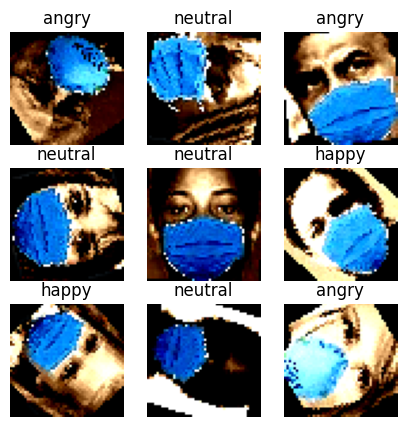

Device: cuda:0


In [401]:

train_paths=['D:/Datasets/Natural-Faces/train/','D:/Datasets/Tiny/train/','D:/Datasets/FerMasked/train/']


mdl_path='D:/Datasets/Models/'
img_path='D:/Datasets/Images/'  # CHANGE ALL 4 PATHS BASED ON UR FOLDER LOCATIONS (FOR MODEL/IMG PATH MAKE SURE TO CREATE FOLDERS)

mn=[[0.4752, 0.4752, 0.4752],[0.4879, 0.4236, 0.3958],[0.4149, 0.4694, 0.5233]]
sd=[[0.2756, 0.2756, 0.2756],[0.3012, 0.2763, 0.2730],[0.2617, 0.2725, 0.3079]]


batch_size=32
image_size=(224,224)
num_epochs=100
learning_rate=0.001
weight_dec=0.001

ta,tl,va,vl,lbl=[],[],[],[],[]


dtaname=['Natural-Faces','Tiny','Fer-Masked']
mdls=[torchvision.models.shufflenet_v2_x0_5(),torchvision.models.mnasnet0_5(),torchvision.models.mobilenet_v2()]
mdlname=['Shufflenet','MnasNet','MobileNetV2'] 

# mdls=[torchvision.models.vgg16(weights=True),model_vgg_frozen,torchvision.models.resnet50(weights=True),model_resnet_frozen]  # CHANGE THIS ACCORDING TO NEED
# mdlname=['VGG-16 Fine_tuning','VGG16 Deep_tuning','Resnet Fine_tuning','Resnet Deep_tuning'] # UPDATE BASED ON LIST ABOVE





for i in range(0,len(train_paths)):
    for k in range (0,len(mdls)):
        
        train_folder=train_paths[i]
        
        train_loader,test_loader,val_loader,lablist=load_data(train_folder,batch_size,image_size,mn[i],sd[i])
        
        # mean, std = batch_mean_and_sd(train_loader)
        # print("mean and std: \n", mean, std)
        
        img_show(train_loader,lablist)
        model=mdls[k]#model reinitialized to prevent transfer learning on the other data sets
        
        
        
        
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        exp_lr_scheduler=torch.optim.lr_scheduler.StepLR(optimizer=optimizer,step_size=20,gamma=0.5) # SCHEDULED LEARNING RATE

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print("Device: {}".format(device))
        model.to(device)
        
        print('----------PARAMETERS----------') #PRINTING NO OF PARAMTERS FOR A GIVEN INPUT SIZE
        summary(model, (3,224,224))
        print('----------FLOPS----------')  #PRINTING NO OF FLOPS FOR A GIVEN INPUT SIZE
        count_ops(model, torch.rand(1,3,224,224).to(device))
        
        
        model,t_acc,v_acc,t_loss,v_loss,epc,time_taken=train_model(num_epochs,train_loader,val_loader) # TRAINING MODEL
        ta.append(t_acc)
        tl.append(t_loss)
        va.append(v_acc)
        vl.append(v_loss)
        
        time_taken=round((time_taken/60),2)
        title=mdlname[k]+' '+dtaname[i]
        print(title)
        lbl.append(title)
        
        # grp_show(epc,[t_acc,v_acc],['Training','Valiation'],['b','r'],'Epochs ('+str(time_taken)+' minutes)','Accuracies','Accuracy Comparision '+title,img_path) #DISPLAYING AND STORING GRAPHS
        # grp_show(epc,[t_loss,v_loss],['Training','Valiation'],['b','r'],'Epochs ('+str(time_taken)+' minutes)','Losses','Loss Comparision '+title,img_path)
    
        test_model(model,test_loader)  # TESTING MODEL
        torch.save(model, mdl_path+title) # SAVING MODEL
        torch.cuda.empty_cache() 


grp_show(epc,ta,lbl,'Epochs','Training Accuracies','Training Accuracy Comparision',img_path) #DISPLAYING AND STORING GRAPHS
grp_show(epc,tl,lbl,'Epochs','Training Losses','Training Loss Comparision',img_path)
grp_show(epc,va,lbl,'Epochs','Validation Accuracies','Validation Accuracy Comparision',img_path)
grp_show(epc,vl,lbl,'Epochs','Validation Losses','Validation Loss Comparision',img_path)
    
    
    


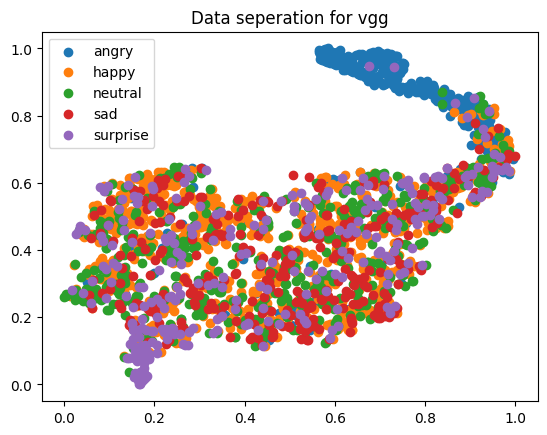

In [406]:

# mdl_path='D:/Datasets/Models/'
# img_path='D:/Datasets/Images/'

mdlist=[torch.load(mdl_path+'VGG-16 Fine_tuning Fer-Masked'),]
titles=['Data seperation for vgg']
for i in range(0,len(mdlist)):

    model=mdlist[i]

    model = torch.nn.Sequential(*(list(model.children())[:-1]))

    model.to(device)
    model.eval()

    


    features,labels=calcfeatures(test_loader,model)
    print(features.shape)
    print(len(labels))
    tsne = TSNE(n_components=2).fit_transform(features)

    tx = tsne[:, 0]
    ty = tsne[:, 1]
    
    tx = scale_to_01_range(tx)
    ty = scale_to_01_range(ty)
    grpshow(tx,ty,labels,lablist,img_path,titles[i])
                